In [14]:
%load_ext autoreload
%autoreload 2
import polars as pl
from scipy.stats import binned_statistic_2d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from src.loading import *
from src.saving import *
from src.plotting import *
from src.regions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load global PF stats
# (Takes about 7 sec)
pf_stats = load_global_merged_pf_stats()
feb_pf_stats = pf_stats.filter(pl.col("observation_time").dt.month() == 2)

In [3]:
# Bin lat and lon into dx x dx grids
#
dx = 2
lat_grids = np.arange(-90, 90+dx, dx)
lon_grids = np.arange(-180, 180+dx, dx)
OBS_THRESH = 10
def _grid_mean_pf_stat(pf_stats=pf_stats, data_to_bin=None, statistic='count'):
    stat = binned_statistic_2d(
        pf_stats['mean_latitude'],
        pf_stats['mean_longitude'], 
        values = data_to_bin,
        statistic = statistic,
        bins=[lat_grids, lon_grids]
    ).statistic
    return stat

def _format_axis(ax):
    # Set the geographic extent properly (min_lon, max_lon, min_lat, max_lat)
    # ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      xlocs=np.arange(-180, 181, 60),
                      ylocs=np.arange(-30, 31, 15),
                      linewidth=0.5, linestyle='--', color='0.7')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = True
    gl.top_labels = False

    ax.coastlines(color='black', linewidth=0.8)
    EPS = 1e-6  # nudge off the antimeridian
    ax.set_extent([-180+EPS, 180-EPS, -30, 30], crs=ccrs.PlateCarree())
    return ax

# Counts of PFs

Text(0.5, 1.0, 'PF Counts, Jan 2015 - Dec 2022')

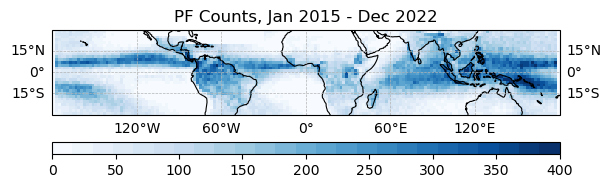

In [4]:
# Counts of PFs
#
pf_count = _grid_mean_pf_stat()
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    pf_count,
    cmap=discrete_cmap('Blues', 25),
    norm=colors.Normalize(vmin=0, vmax=400),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax = _format_axis(ax)
ax.set_title('PF Counts, Jan 2015 - Dec 2022')
# save_figure(fig, 'Tropical PF Counts.pdf')

# ExPF Fraction

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_16211/405951079.py:6: RuntimeWarning: invalid value encountered in divide
  ex_pf_frac = 100*ex_pf_count/pf_count


Text(0.5, 1.0, 'ExPF Percentage of PFs, Jan 2015 - Dec 2022')

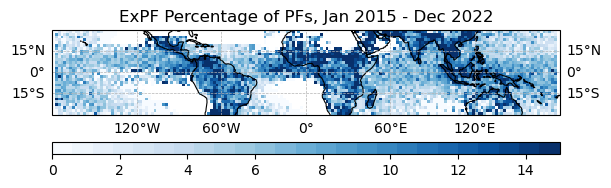

In [5]:
# Fraction of PFs over a given region that are extreme
#
extreme_pf_mask = pf_stats['max_precip'] >= 60
ex_pf_count = _grid_mean_pf_stat(data_to_bin=extreme_pf_mask, statistic='sum')
pf_count = _grid_mean_pf_stat()
ex_pf_frac = 100*ex_pf_count/pf_count
ex_pf_frac[pf_count<OBS_THRESH] = np.nan
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    ex_pf_frac,
    cmap=discrete_cmap('Blues', 25),
    norm=colors.Normalize(vmin=0, vmax=15),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax = _format_axis(ax)
ax.set_title('ExPF Percentage of PFs, Jan 2015 - Dec 2022')

# Morphology of NonExPFs and ExPFs

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_16211/738748506.py:10: RuntimeWarning: Mean of empty slice
  statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan


Text(0.5, 1.0, 'Non-ExPF Mean Localization')

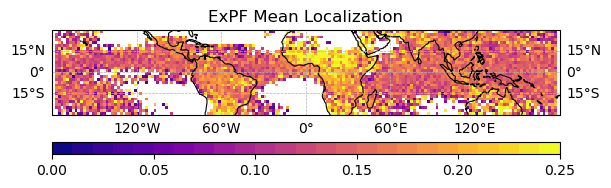

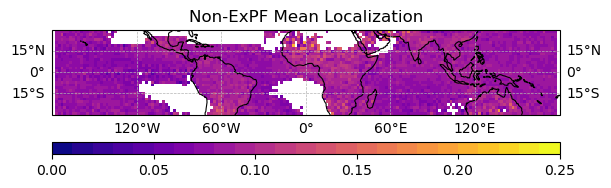

In [6]:
# Localization indices of the PFs
#
loc = pf_stats['largest_10mmhr_cluster_size_pixels'] / pf_stats['num_pixels']

# Separate areas of extremes and non-extremes
#
expf_loc = loc.set(~(pf_stats["max_precip"] >= 60), np.nan)     # Nan out where max precip is too low
non_expf_loc = loc.set(~(pf_stats["max_precip"] <= 20), np.nan) # Nan out where max precip is too high

statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan
expf_mean_loc = _grid_mean_pf_stat(data_to_bin=expf_loc, statistic=statistic)
non_expf_mean_loc = _grid_mean_pf_stat(data_to_bin=non_expf_loc, statistic=statistic)

# Extreme PFs
#
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    expf_mean_loc,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.Normalize(vmin=0, vmax=0.25),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax = _format_axis(ax)
ax.set_title('ExPF Mean Localization')

# Non-Extreme PFs
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    non_expf_mean_loc,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.Normalize(vmin=0, vmax=0.25),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax = _format_axis(ax)
ax.set_title('Non-ExPF Mean Localization')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_16211/466840617.py:9: RuntimeWarning: Mean of empty slice
  statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan


Text(0.5, 1.0, 'Non-ExPF Mean Principal Core Size')

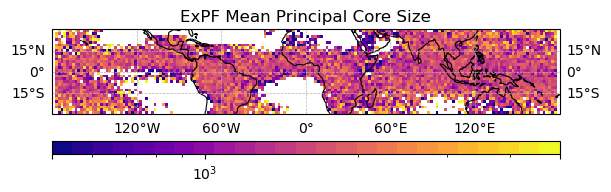

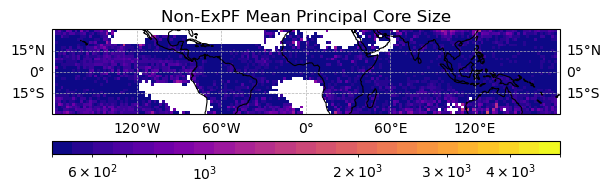

In [7]:
# Sizes of the PFs
#
area = pf_stats['num_pixels'] * 25.0
# Separate area of extremes and non-extremes
#
expf_area = area.set(~(pf_stats["max_precip"] >= 60), np.nan)     # Nan out where max precip is too low
non_expf_area = area.set(~(pf_stats["max_precip"] <= 20), np.nan) # Nan out where max precip is too high

statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan
expf_mean_area = _grid_mean_pf_stat(data_to_bin=expf_area, statistic=statistic)
non_expf_mean_area = _grid_mean_pf_stat(data_to_bin=non_expf_area, statistic=statistic)

# Extreme PFs
#
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    expf_mean_area,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.LogNorm(vmin=500, vmax=5e3),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
cb.ax.set_xticks([500, 1000, 5_000])
ax = _format_axis(ax)
ax.set_title('ExPF Mean Principal Core Size')

# Non-Extreme PFs
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    non_expf_mean_area,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.LogNorm(vmin=500, vmax=5e3),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax = _format_axis(ax)
ax.set_title('Non-ExPF Mean Principal Core Size')

# Feburary ExPFs

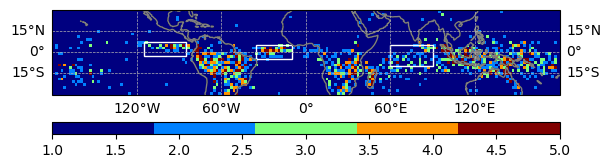

In [15]:
# Distribution of Feb (Ex)Fs
#
extreme_feb_pf_mask = feb_pf_stats['max_precip'] >= 60
ex_feb_pf_count = _grid_mean_pf_stat(pf_stats=feb_pf_stats, data_to_bin=extreme_feb_pf_mask, statistic='sum')
feb_pf_count = _grid_mean_pf_stat(pf_stats=feb_pf_stats, statistic='count')

# Put in /year units
#
# Plot the count of ExFeb PFs
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
cmap = discrete_cmap('jet', 5).copy()
cmap.set_bad(color='white')   # for masked values
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    ex_feb_pf_count,
    cmap=cmap,
    norm=colors.Normalize(vmin=1, vmax=5),
    transform=ccrs.PlateCarree()
)

cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax = _format_axis(ax)
ax.coastlines(color='grey')

for region in ['EqIO', 'AtlITCZ', 'PacITCZ']:
    region_dict = get_gsam_region_dict(region)
    rect = mpatches.Rectangle(
        (region_dict['lon_west'], region_dict['lat_south']),   # lower-left corner
        region_dict['lon_east'] - region_dict['lon_west'],     # width (lon range)
        region_dict['lat_north'] - region_dict['lat_south'],   # height (lat range)
        linewidth=1,
        edgecolor='white',
        facecolor='None',
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

In [17]:
f = '~/Datasets/uw_trmm_gpm/precipitation_features/gpm_pf_stats.AFC.2015.01.csv'
df = pl.read_csv(f)